<a href="https://colab.research.google.com/github/prateekkosta/Machine-Learning-Models/blob/main/Time_Series_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Objective**: Build a model to forecast the demand(passenger traffic) in Airplanes. The data is classified in date/time and the passengers travelling per month

In [1]:
from IPython.core.interactiveshell import warnings
from logging import warning
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
rcParams['figure.figsize']= 10,6
import warnings
warnings.filterwarnings('ignore')

!pip install pmdarima
import pmdarima as pm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00


**Read Data**
Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [2]:
import io
from google.colab import files
uploaded= files.upload()

Saving AirPassengers.csv to AirPassengers.csv


In [3]:
dataset= pd.read_csv(io.BytesIO(uploaded['AirPassengers.csv']))

dataset.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
dataset.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


COnverting Object Datatype to Date Time format

In [6]:
dataset['Month']= pd.to_datetime(dataset['Month'], infer_datetime_format= True)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


Making Month Column as Index column

In [8]:
indexedDataset= dataset.set_index(['Month'])

indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Now Checking For Trend Component in Data

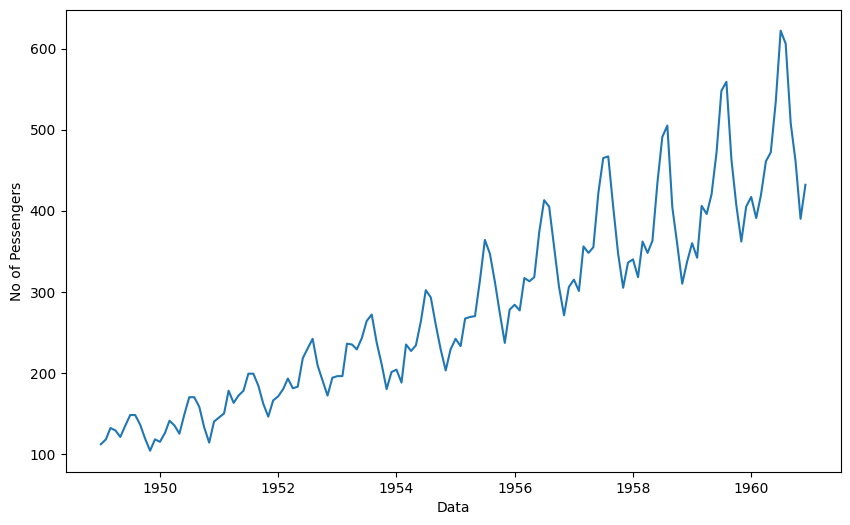

In [9]:
# Plotting Graph

plt.xlabel('Data')
plt.ylabel('No of Pessengers')
plt.plot(indexedDataset)


Analysis Of Graph-  

1.  Graph has a upward trend.
2.  It has Seasonality.
3.  It looks like Multiplicative Time series


      

## **Decomposing Time Series**

<function matplotlib.pyplot.show(close=None, block=None)>

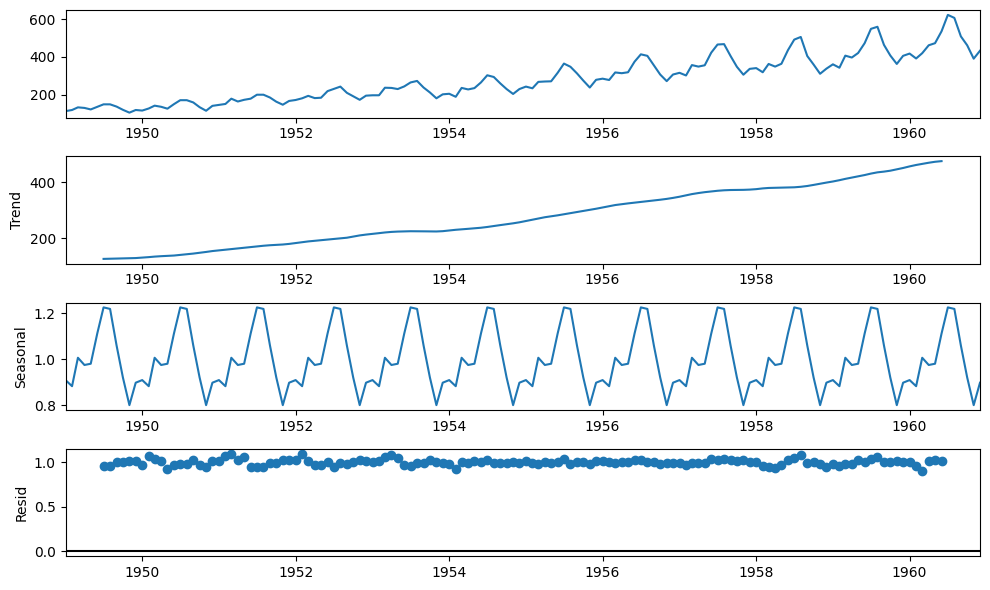

In [10]:
# Data clealy has a linear Uptrend
# a clear cut seasonal pattern of a 1 year duration is present in the data

dec= seasonal_decompose(indexedDataset, model= 'multiplicative', period = 12).plot()
plt.show

Extracting the values for Trend, Seasonal and Residual from Decompossed Data

In [11]:
decomposed= seasonal_decompose(indexedDataset, period= 12, model = 'multiplicative')
original_vs_decompossed_series = pd.concat([decomposed.observed, decomposed.trend, decomposed.seasonal, decomposed.resid], axis= 1)
original_vs_decompossed_series.columns= ['Actual','Trend','Seasonal','Residual or Unexplained']
original_vs_decompossed_series.to_csv('original_vs_decompossed_series.csv')
files.download('original_vs_decompossed_series.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
original_vs_decompossed_series= original_vs_decompossed_series.reset_index()
original_vs_decompossed_series.head(5)

,Month,Actual,Trend,Seasonal,Residual or Unexplained
0,1949-01-01,112.0,NaN,0.910230,NaN
1,1949-02-01,118.0,NaN,0.883625,NaN
2,1949-03-01,132.0,NaN,1.007366,NaN
3,1949-04-01,129.0,NaN,0.975906,NaN
4,1949-05-01,121.0,NaN,0.981378,NaN


In [14]:
#Adding rank column in Decompossed series
#creating the rank column and passing the returned rank series

original_vs_decompossed_series['Rank']= original_vs_decompossed_series['Month'].rank()

In [16]:
original_vs_decompossed_series.head(5)

,Month,Actual,Trend,Seasonal,Residual or Unexplained,Rank
0,1949-01-01,112.0,NaN,0.910230,NaN,1.0
1,1949-02-01,118.0,NaN,0.883625,NaN,2.0
2,1949-03-01,132.0,NaN,1.007366,NaN,3.0
3,1949-04-01,129.0,NaN,0.975906,NaN,4.0
4,1949-05-01,121.0,NaN,0.981378,NaN,5.0


In [15]:
#spliting the data into x and y

data_for_model = original_vs_decompossed_series.dropna()
x= data_for_model.loc[:,['Rank']]
y= data_for_model['Trend']

#fitting a linear model
x= sm.add_constant(x)
model = sm.OLS(y,x).fit()

In [18]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Trend   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.134e+04
Date:                Fri, 23 Jun 2023   Prob (F-statistic):          2.38e-128
Time:                        18:45:35   Log-Likelihood:                -502.37
No. Observations:                 132   AIC:                             1009.
Df Residuals:                     130   BIC:                             1015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.6483      2.051     41.272      0.0

In [19]:
#predicting Trend values

original_vs_decompossed_series['Predicted_trend']= (original_vs_decompossed_series['Rank']*2.6669 +84.6483)
original_vs_decompossed_series.head(5)

,Month,Actual,Trend,Seasonal,Residual or Unexplained,Rank,Predicted_trend
0,1949-01-01,112.0,NaN,0.910230,NaN,1.0,87.3152
1,1949-02-01,118.0,NaN,0.883625,NaN,2.0,89.9821
2,1949-03-01,132.0,NaN,1.007366,NaN,3.0,92.6490
3,1949-04-01,129.0,NaN,0.975906,NaN,4.0,95.3159
4,1949-05-01,121.0,NaN,0.981378,NaN,5.0,97.9828


In [20]:
original_vs_decompossed_series['predicted_timeseries']= original_vs_decompossed_series['Predicted_trend']*original_vs_decompossed_series['Seasonal']

Plotting Basic Model


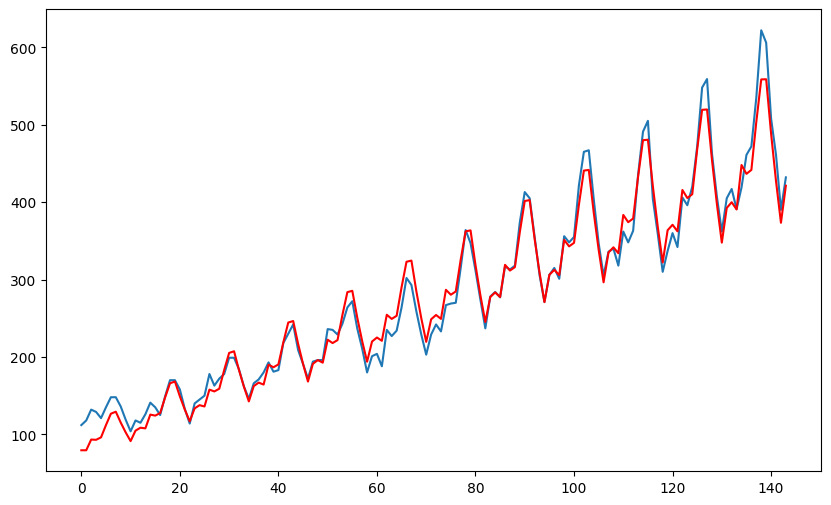

In [22]:
plt.plot(original_vs_decompossed_series['Actual'])
plt.plot(original_vs_decompossed_series['predicted_timeseries'], color= 'red')
print('Plotting Basic Model')

In [24]:
error= np.sqrt(mean_squared_error(original_vs_decompossed_series['Actual'], original_vs_decompossed_series['predicted_timeseries']))
print('Total RMSE : %.4f' %error)

Total RMSE : 17.3236


## **fbprophet Package for Time series Modeling**

In [25]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import prophet
from prophet import Prophet

In [29]:
dataset_fb = dataset
dataset_fb.columns = ['ds', 'y']
model = Prophet(seasonality_mode= 'multiplicative')
model.fit(dataset_fb)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbh5m0e72/0mkhjuwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbh5m0e72/4248q8fj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93278', 'data', 'file=/tmp/tmpbh5m0e72/0mkhjuwp.json', 'init=/tmp/tmpbh5m0e72/4248q8fj.json', 'output', 'file=/tmp/tmpbh5m0e72/prophet_modeleydrll0c/prophet_model-20230623191210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
future = model.make_future_dataframe(periods = 36,freq= 'M')

In [35]:
pred= model.predict(future)
pred[['ds','yhat']].head()

,ds,yhat
0,1949-01-01,104.158588
1,1949-02-01,100.636315
2,1949-03-01,115.099045
3,1949-04-01,116.677798
4,1949-05-01,119.542212


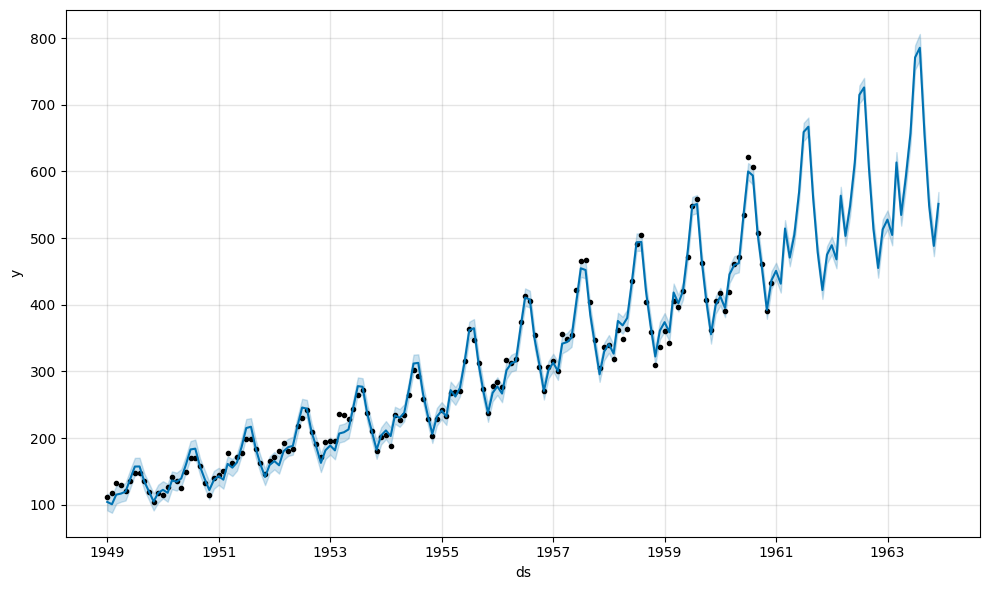

In [36]:
#Multipicative

plot_model = model.plot(pred)

In [37]:
error= np.sqrt(mean_squared_error(dataset_fb['y'],pred.loc[0:143,'yhat']))
print("total RMSE: %.4f" %error)

total RMSE: 10.2000


**The Error trend while Using FB Prophet is 10 where as while using traditional method it was 17.**